# Imports

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch import nn, cdist
# Utility to set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Parsing Meta-Data

In [2]:
import os
import random
from collections import defaultdict
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CUBFewShotDataset(Dataset):
    def __init__(self, root, class_ids, transform=None):
        self.root = root
        self.transform = transform
        self.class_ids = class_ids  # A set of allowed class labels

        # Load meta files
        images_txt = os.path.join(root, 'images.txt')
        labels_txt = os.path.join(root, 'image_class_labels.txt')

        # Parse image paths and labels
        with open(images_txt, 'r') as f:
            id_to_path = {int(i): p for i, p in (line.strip().split() for line in f)}

        with open(labels_txt, 'r') as f:
            id_to_label = {int(i): int(l) - 1 for i, l in (line.strip().split() for line in f)}

        # Build class-to-images dict for selected class_ids
        self.class_to_images = defaultdict(list)
        for img_id in id_to_path:
            label = id_to_label[img_id]
            if label in class_ids:
                img_path = os.path.join(root, 'images', id_to_path[img_id])
                self.class_to_images[label].append(img_path)

        # Flatten (image_path, label) list
        self.data = [(img, cls) for cls, imgs in self.class_to_images.items() for img in imgs]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
def get_class_splits(num_classes=200, seed=13):
    class_ids = list(range(num_classes))
    random.seed(seed)
    random.shuffle(class_ids)

    train_classes = class_ids[:100]
    val_classes = class_ids[100:150]
    test_classes = class_ids[150:]

    return train_classes, val_classes, test_classes


# Define Transforms and Loaders

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

data_root = '/kaggle/input/cub2002011/CUB_200_2011'

train_ids, val_ids, test_ids = get_class_splits()

train_data = CUBFewShotDataset(root=data_root, class_ids=set(train_ids), transform=transform)
val_data   = CUBFewShotDataset(root=data_root, class_ids=set(val_ids), transform=transform)
test_data  = CUBFewShotDataset(root=data_root, class_ids=set(test_ids), transform=transform)


In [5]:
image, label = train_data[0]
image, label

(tensor([[[-1.2536e-01, -1.5758e-01, -1.2887e-01,  ..., -5.4903e-01,
           -3.7679e-01, -2.6823e-01],
          [-1.7407e-01, -1.9057e-01, -3.5158e-02,  ..., -3.6263e-02,
            7.3509e-02,  1.5248e-01],
          [-3.9328e-01, -3.4610e-01, -1.5846e-01,  ...,  3.0824e-01,
            1.8196e-01,  1.3500e-01],
          ...,
          [-6.4083e-02, -1.7226e-02,  3.0398e-02,  ..., -4.0527e-01,
           -2.7965e-01, -2.3213e-01],
          [-4.3783e-01, -4.5257e-01, -3.7459e-01,  ..., -2.3424e-01,
           -1.3920e-01, -6.0890e-02],
          [-6.3591e-01, -6.0567e-01, -5.1361e-01,  ..., -1.8783e-01,
           -1.5626e-01, -1.7111e-01]],
 
         [[ 2.5189e-01,  2.5235e-01,  3.3182e-01,  ...,  2.5119e-03,
            1.1178e-01,  2.0606e-01],
          [ 2.5220e-01,  2.6874e-01,  3.9421e-01,  ...,  4.2649e-01,
            4.8860e-01,  5.1922e-01],
          [ 1.1163e-01,  1.4315e-01,  2.6816e-01,  ...,  6.2834e-01,
            5.8277e-01,  5.5146e-01],
          ...,
    

In [6]:
image.shape  # CHW

torch.Size([3, 224, 224])

In [7]:
print("Number of training samples:", len(train_data))
print("Number of testing samples:", len(test_data))

Number of training samples: 5879
Number of testing samples: 2958


# Visualize

Image shape: torch.Size([3, 224, 224])


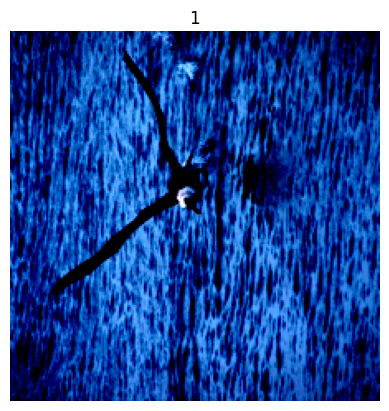

In [8]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(2,1,0)) # image shape is [3, 32, 32] (colour channels, height, width)
plt.axis('off')
plt.title(label);

In [9]:
# # Get all labels in train and test datasets
# train_labels = [label for _, label in train_data]
# test_labels = [label for _, label in test_data]

# # Convert to sets to get unique values
# unique_train_labels = set(train_labels)
# unique_test_labels = set(test_labels)

# print("Unique labels in train data:", sorted(unique_train_labels))
# print("Unique labels in test data:", sorted(unique_test_labels))

# print("\nNumber of unique labels in train:", len(unique_train_labels))
# print("Number of unique labels in test:", len(unique_test_labels))


# Episode Sampler

In [10]:
def sample_episode(class_to_images, Nc, Ns, Nq, transform):
    """
    Sample a few-shot episode.
    Returns: (prototypes_tensor, query_tensors, query_labels)
    """
    selected_classes = random.sample(list(class_to_images.keys()), Nc)
    prototypes = []
    query_tensors = []
    query_labels = []

    for class_idx, cls in enumerate(selected_classes):
        images = class_to_images[cls]
        sampled_images = random.sample(images, Ns + Nq)

        support_paths = sampled_images[:Ns]
        query_paths = sampled_images[Ns:]

        support_images = [transform(Image.open(p).convert('RGB')) for p in support_paths]
        query_images = [transform(Image.open(p).convert('RGB')) for p in query_paths]

        support_tensor = torch.stack(support_images)
        query_tensor = torch.stack(query_images)

        # Embed support to get prototype
        prototype = model(support_tensor.to(device)).mean(0)  # [embedding_dim]
        prototypes.append(prototype)

        query_tensors.append(query_tensor)
        query_labels += [class_idx] * Nq  # map to episodic index

    prototypes_tensor = torch.stack(prototypes).unsqueeze(0)  # [1, Nc, D]
    query_tensors = torch.cat(query_tensors, dim=0)  # [Nc*Nq, 3, 224, 224]
    query_labels = torch.tensor(query_labels)  # [Nc*Nq]

    return prototypes_tensor, query_tensors, query_labels


# TinyVGG

In [11]:
import torch
import torch.nn as nn

class ProtoNetEncoder(nn.Module):
    """
        Model Architecture that replicates the TinyVGG
        model from CNN explainer website
    """
    def __init__(self, input_shape, hidden_units, output_shape, dropout_rate=0.5):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout_rate)

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            self.dropout
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            self.dropout
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            self.dropout
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 28 * 28, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x


In [12]:
model = ProtoNetEncoder(3,100,512).to(device)

In [13]:
# output=model(image.unsqueeze(0).to(device))

In [14]:
# from torchvision.models import resnet18
# # No weights - random initialization
# model=resnet18(weights=None)
# num_ftrs = model.fc.in_features
# print(num_ftrs)
# model.fc = nn.Linear(num_ftrs, 64)  
# model.to(device)

In [15]:
# from torchvision import models
# import torch.nn as nn
# class ResNet18WithDropout(nn.Module):
#     def __init__(self, dropout_rate=0.5, embedding_dim=512):
#         super(ResNet18WithDropout, self).__init__()
#         base_model = models.resnet18(pretrained=True)
        
#         # Remove the final classification layer (fc)
#         self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Output: [B, 512, 1, 1]
        
#         # Add Dropout + FC to get final embeddings
#         self.dropout = nn.Dropout(p=dropout_rate)
#         self.embedding = nn.Linear(512, embedding_dim)

#     def forward(self, x):
#         x = self.feature_extractor(x)  # [B, 512, 1, 1]
#         x = x.view(x.size(0), -1)      # Flatten to [B, 512]
#         x = self.dropout(x)
#         x = self.embedding(x)          # Optional: normalize embeddings if needed
#         return x


In [16]:
# model = ResNet18WithDropout(dropout_rate=0.5).to(device)


# Train_Loop

In [17]:
Nc=5 # class per episode
Ns=1
Nq=5
num_episodes=50000
print_interval = 1000

In [18]:
loss_function = nn.LogSoftmax(dim=1)  # softmax across classes
norm = 1 / (Nc * Nq)
# opt = torch.optim.Adam(model.parameters(), lr=0.001)
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
recent_loss = []
recent_accuracy = []

for e in range(1, num_episodes + 1):
    prototypes_tensor, query_tensors, query_labels = sample_episode(train_data.class_to_images, Nc, Ns, Nq, transform)

    query_embeddings = model(query_tensors.to(device)).unsqueeze(0)  # [1, Nc*Nq, D]

    distances = -cdist(prototypes_tensor, query_embeddings).squeeze(0)  # [Nc, Nc*Nq]
    log_probs = loss_function(distances.T)  # [Nc*Nq, Nc]
    loss = nn.NLLLoss()(log_probs, query_labels.to(device))

    opt.zero_grad()
    loss.backward()
    opt.step()

    # Accuracy
    preds = log_probs.argmax(dim=1)
    acc = (preds == query_labels.to(device)).float().mean().item()

    recent_loss.append(loss.item())
    recent_accuracy.append(acc)

    if e % print_interval == 0:
        print(f"[Episode {e}] Loss: {np.mean(recent_loss):.4f}, Acc: {np.mean(recent_accuracy)*100:.2f}%")
        recent_loss = []
        recent_accuracy = []

    # --- t-SNE Plotting ---
    # if e % 50 == 0:
    #     from sklearn.manifold import TSNE
    #     import matplotlib.pyplot as plt
    #     import os

    #     tsne_dir = "tsne_cub"
    #     os.makedirs(tsne_dir, exist_ok=True)

    #     embeddings = query_embeddings.squeeze(0).detach().cpu()
    #     tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    #     tsne_result = tsne.fit_transform(embeddings)

    #     plt.figure(figsize=(10, 8))
    #     scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=query_labels, cmap='tab20', s=10)
    #     plt.title(f"t-SNE of Query Embeddings at Episode {e}")
    #     plt.colorbar(scatter, ticks=range(min(20, Nc)))
    #     plt.tight_layout()

    #     plot_path = os.path.join(tsne_dir, f"tsne_episode_{e}.png")
    #     plt.savefig(plot_path)
    #     plt.close()


[Episode 1000] Loss: 1.4944, Acc: 32.98%
[Episode 2000] Loss: 1.3848, Acc: 40.18%
[Episode 3000] Loss: 1.3084, Acc: 45.68%


# Testing

In [ ]:
print_interval = 10

In [ ]:
# def evaluate_few_shot(model, class_to_images, Nc=5, Ns=1, Nq=5, num_episodes=200):
#     model.eval()
#     total_accuracy = []

#     with torch.no_grad():
#         for _ in range(num_episodes):
#             # Sample an episode
#             prototypes_tensor, query_tensors, query_labels = sample_episode(
#                 class_to_images, Nc, Ns, Nq, transform
#             )

#             query_embeddings = model(query_tensors.to(device)).unsqueeze(0)  # [1, Nc*Nq, D]
#             distances = -cdist(prototypes_tensor, query_embeddings).squeeze(0)  # [Nc, Nc*Nq]
#             log_probs = loss_function(distances.T)  # [Nc*Nq, Nc]

#             preds = torch.argmax(log_probs, dim=1)
#             acc = (preds == query_labels.to(device)).float().mean().item()
#             total_accuracy.append(acc)

#     avg_acc = np.mean(total_accuracy)
#     print(f"[Test Few-Shot] Average Accuracy over {num_episodes} episodes: {avg_acc * 100:.2f}%")
#     return avg_acc


In [ ]:
# test_acc = evaluate_few_shot(model, test_data.class_to_images, Nc=50, Ns=5, Nq=15)

In [ ]:
# test_acc

# Saving Model

In [ ]:
from pathlib import Path
import torch

# Save directory in Kaggle
MODEL_PATH = Path("/kaggle/working/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Model file name and save path
MODEL_NAME = "ProtoNetEncoder.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model's state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)


In [ ]:
num_test_episodes=200
Nc=5

In [ ]:
loss_function = nn.LogSoftmax(dim=1)  # softmax across classes
recent_loss = []
recent_accuracy = []

model.eval()  # set model to evaluation mode
with torch.no_grad():  # disable gradient computation
    for e in range(1, num_test_episodes + 1):
        prototypes_tensor, query_tensors, query_labels = sample_episode(
            test_data.class_to_images, Nc, Ns, Nq, transform
        )

        query_embeddings = model(query_tensors.to(device)).unsqueeze(0)  # [1, Nc*Nq, D]

        distances = -cdist(prototypes_tensor, query_embeddings).squeeze(0)  # [Nc, Nc*Nq]
        log_probs = loss_function(distances.T)  # [Nc*Nq, Nc]
        loss = nn.NLLLoss()(log_probs, query_labels.to(device))

        # Accuracy
        preds = log_probs.argmax(dim=1)
        acc = (preds == query_labels.to(device)).float().mean().item()

        recent_loss.append(loss.item())
        recent_accuracy.append(acc)

        if e % print_interval == 0:
            print(f"[Test Episode {e}] Loss: {np.mean(recent_loss):.4f}, Acc: {np.mean(recent_accuracy)*100:.2f}%")
            recent_loss = []
            recent_accuracy = []


In [ ]:
loss_function = nn.LogSoftmax(dim=1)  # softmax across classes
recent_loss = []
recent_accuracy = []

model.eval()  # set model to evaluation mode
with torch.no_grad():  # disable gradient computation
    for e in range(1, num_test_episodes + 1):
        prototypes_tensor, query_tensors, query_labels = sample_episode(
            val_data.class_to_images, Nc, Ns, Nq, transform
        )

        query_embeddings = model(query_tensors.to(device)).unsqueeze(0)  # [1, Nc*Nq, D]

        distances = -cdist(prototypes_tensor, query_embeddings).squeeze(0)  # [Nc, Nc*Nq]
        log_probs = loss_function(distances.T)  # [Nc*Nq, Nc]
        loss = nn.NLLLoss()(log_probs, query_labels.to(device))

        # Accuracy
        preds = log_probs.argmax(dim=1)
        acc = (preds == query_labels.to(device)).float().mean().item()

        recent_loss.append(loss.item())
        recent_accuracy.append(acc)

        if e % print_interval == 0:
            print(f"[Test Episode {e}] Loss: {np.mean(recent_loss):.4f}, Acc: {np.mean(recent_accuracy)*100:.2f}%")
            recent_loss = []
            recent_accuracy = []
